# Observational study

The goal of the present project is to define a valid metric to evaluate the impact of actors on movies. Specifically, distilling actors careers to a single number, the *star score*. Identifying the latter implies the need to identify truly successful actors, namely actors that had the highest positive impact on movies, in terms of revenues and ratings. Given the presence of multiple confounders, such as the affinity of actors with particulare genres or gender disparities, an observational study is carried out to limit the influence of unobserved covariates.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
%matplotlib inline

import datetime as dt
import networkx as nx
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.weightstats import ztest
import re
import warnings
warnings.filterwarnings('ignore')

In [249]:
#importing our clean data
data = pd.read_csv('../data/data.csv', index_col = 0)
data_profit = pd.read_csv('../data/profit_data.csv', index_col = 0)
actors = pd.read_csv('../data/actorMetrics.csv', index_col = 0)
imdb = pd.read_csv('../data/imdb_budgets.csv', index_col = 0)
ss = pd.read_csv('obs.csv', index_col = 0)

In [115]:
df = pd.read_csv('../data/imdb_no_nan.csv',)
df_y = ak = pd.read_csv('../data/name.basics.tsv.gz',compression='infer',sep='\t')
#ak = pd.read_csv('../data/title.akas.tsv.gz',compression='infer',sep='\t')

In [116]:
df_y = df_y.replace(r'\N', np.nan)

In [124]:
df_y.dropna(subset=['birthYear'],inplace=True)

In [125]:
df_y

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0053137,tt0045537,tt0050419"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0038355,tt0071877,tt0037382"
2,nm0000003,Brigitte Bardot,1934,NaN,"actress,soundtrack,music_department","tt0049189,tt0056404,tt0054452,tt0057345"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0077975,tt0078723,tt0080455,tt0072562"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0050976,tt0050986,tt0060827"
...,...,...,...,...,...,...
12150703,nm9993436,Frank J. Gaily,1915,2008,sound_department,tt0189339
12150785,nm9993526,Ben Ray Lujan,1972,NaN,NaN,"tt15385660,tt4209386,tt7516996,tt0476038"
12150793,nm9993535,Henry Lawfull,2006,NaN,actor,"tt5900600,tt10187208"
12150914,nm9993675,Ebrahim Alkazi,1925,2020,NaN,NaN


In [120]:
len(df_y)

12150956

In [28]:
ak_regions = ak.groupby('region')[['title']].count().reset_index().sort_values(by=['title'],ascending=False)

In [29]:
ak_regions = ak.groupby('region')[['title']].count().reset_index().sort_values(by=['title'],ascending=False)
ak_regions[ak_regions['region'] == 'IT']

,region,title
104,IT,3979858


In [30]:
imdb_g = df.merge(ak, 'inner', left_on='tconst', right_on='titleId')
imdb_g.drop(['title'],axis=1,inplace=True)
imdb_regions = imdb_g.groupby('region')[['primaryTitle']].count().reset_index().sort_values(by=['primaryTitle'],ascending=False)

In [31]:
kaggle = pd.read_csv('../data/kaggle_movies_metadata.csv')

In [32]:
len(kaggle)

45466

In [50]:
imdb_kaggle = imdb_g.merge(kaggle, 'inner', left_on='tconst', right_on='imdb_id')

In [51]:
pd.isnull(imdb_kaggle['revenue']).sum()

48

In [52]:
imdb_kaggle.dropna(subset=['revenue'],inplace=True)

In [53]:
imdb_kaggle = imdb_kaggle[imdb_kaggle['revenue'] != 0]

In [54]:
len(imdb_kaggle)

982023

In [62]:
imdb_kaggle.drop(columns=['video','tagline','status','poster_path','production_companies','production_countries','original_title',
                          'popularity','imdb_id','overview','primaryTitle','homepage','titleId','ordering','id','original_language',
                          'belongs_to_collection','adult','isOriginalTitle','attributes','types','genres_y','language',
                          'vote_count','vote_average','spoken_languages'],inplace=True)

In [64]:
us = imdb_kaggle[imdb_kaggle['region'] == 'US']
len(us)

41342

In [129]:
imdb_y = df_y.merge(imdb_g, 'inner', left_on='primaryName', right_on='ActorName')

In [131]:
imdb_y

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,Unnamed: 0,tconst,primaryTitle,startYear,...,Director,category,ActorName,titleId,ordering,region,language,types,attributes,isOriginalTitle
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0053137,tt0045537,tt0050419",26987,tt0025164,The Gay Divorcee,1934,...,Mark Sandrich,actor,Fred Astaire,tt0025164,10,GB,\N,imdbDisplay,\N,0
1,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0053137,tt0045537,tt0050419",26987,tt0025164,The Gay Divorcee,1934,...,Mark Sandrich,actor,Fred Astaire,tt0025164,11,SUHH,ru,imdbDisplay,\N,0
2,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0053137,tt0045537,tt0050419",26987,tt0025164,The Gay Divorcee,1934,...,Mark Sandrich,actor,Fred Astaire,tt0025164,12,GB,\N,alternative,\N,0
3,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0053137,tt0045537,tt0050419",26987,tt0025164,The Gay Divorcee,1934,...,Mark Sandrich,actor,Fred Astaire,tt0025164,13,FR,\N,\N,\N,0
4,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0053137,tt0045537,tt0050419",26987,tt0025164,The Gay Divorcee,1934,...,Mark Sandrich,actor,Fred Astaire,tt0025164,14,PT,\N,imdbDisplay,\N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266183,nm9993693,Apsara Rani,1996,NaN,actress,"tt13847502,tt8302382,tt8737752,tt12856788",621713,tt12856788,Dangerous,2021,...,Ram Gopal Varma,actress,Apsara Rani,tt12856788,5,AE,\N,imdbDisplay,\N,0
6266184,nm9993693,Apsara Rani,1996,NaN,actress,"tt13847502,tt8302382,tt8737752,tt12856788",621713,tt12856788,Dangerous,2021,...,Ram Gopal Varma,actress,Apsara Rani,tt12856788,6,IN,hi,imdbDisplay,\N,0
6266185,nm9993693,Apsara Rani,1996,NaN,actress,"tt13847502,tt8302382,tt8737752,tt12856788",621713,tt12856788,Dangerous,2021,...,Ram Gopal Varma,actress,Apsara Rani,tt12856788,7,ID,en,imdbDisplay,\N,0
6266186,nm9993693,Apsara Rani,1996,NaN,actress,"tt13847502,tt8302382,tt8737752,tt12856788",621713,tt12856788,Dangerous,2021,...,Ram Gopal Varma,actress,Apsara Rani,tt12856788,8,JP,ja,imdbDisplay,\N,0


In [132]:
it = imdb_y[imdb_y['region'] == 'US']
len(it)

498132

In [144]:
it.rename(columns={'primaryTitle':'title','startYear':'year','ActorName':'actor','category':'gender'},inplace=True)

In [145]:
it['gender'][it['gender'] == 'actor'] = 'M'
it['gender'][it['gender'] == 'actress'] = 'F'

In [146]:
it.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,Unnamed: 0,tconst,title,year,...,actor,titleId,ordering,region,language,types,attributes,isOriginalTitle,numVotes_factor,averageRating_adj
25,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0053137,tt0045537,tt0050419",26987,tt0025164,The Gay Divorcee,1934,...,Fred_Astaire,tt0025164,33,US,\N,imdbDisplay,\N,0,0.607910,4.498532
41,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0053137,tt0045537,tt0050419",31088,tt0026942,Roberta,1935,...,Fred_Astaire,tt0026942,14,US,\N,imdbDisplay,\N,0,0.550121,3.850846
80,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0053137,tt0045537,tt0050419",31551,tt0027125,Top Hat,1935,...,Fred_Astaire,tt0027125,32,US,\N,working,\N,0,0.667353,5.138620
90,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0053137,tt0045537,tt0050419",31551,tt0027125,Top Hat,1935,...,Fred_Astaire,tt0027125,9,US,\N,imdbDisplay,\N,0,0.667353,5.138620
101,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0053137,tt0045537,tt0050419",32833,tt0027630,Follow the Fleet,1936,...,Fred_Astaire,tt0027630,1,US,\N,imdbDisplay,\N,0,0.568024,4.032972


In [147]:
def minMaxScale(data, imposed_minimum = None, imposed_maximum = None, fit = False): #min max scaling
    mini = min(data)
    maxi = max(data)
    
    if (imposed_minimum != None): mini = imposed_minimum
    if (imposed_maximum != None): maxi = imposed_maximum
    if (fit == False):
        return (data - mini)/(maxi - mini)
    else: 
        return [mini, maxi]

it['numVotes_factor'] = minMaxScale(np.log(it['numVotes']), 0)
it['averageRating_adj'] =  it['averageRating']* it['numVotes_factor']

In [148]:
it['actor'] = it["actor"].apply(lambda x : '_'.join(x.split())) #simplifying actor names
it['Director'] = it["Director"].apply(lambda x : '_'.join(x.split())) #simplifying actor names

actorMetrics = pd.DataFrame(it['actor'].drop_duplicates().reset_index(drop = True)) #creation of starscore dataf

timeScores = pd.DataFrame(it['actor'].drop_duplicates().reset_index(drop = True))

In [149]:
gender = it[['actor','gender']].drop_duplicates(subset=['actor']).reset_index()

In [150]:
movie_year = it[['actor','year']].drop_duplicates(subset=['actor']).reset_index()

In [157]:
birth_year = it[['actor','birthYear']].drop_duplicates(subset=['actor']).reset_index()

In [151]:
year = it.groupby('actor')['year'].mean().reset_index()

In [152]:
it.to_csv('../data/movies_us.csv')

In [153]:
actors['gender'] = gender['gender']

In [154]:
actors['year_avg'] = year['year']

In [158]:
actors['birth_year'] = birth_year['birthYear']

In [159]:
actors.to_csv('../data/actors_us.csv')

In [164]:
actors.dropna(subset=['birth_year'],inplace=True)

In [187]:
metrics_avg = {'averageRating_adj' : 'grade_avg'}
metrics_sum = {'averageRating_adj' : 'grade_sum'}

for idx, (key, value) in enumerate(metrics_avg.items()):
    print(idx)
    lists_per_actor = it.groupby('actor').apply(lambda x : np.mean(x[key])).reindex(
        index = actorMetrics['actor'].values)
    actorMetrics[value] = lists_per_actor.values
       
for idx, (key, value) in enumerate(metrics_sum.items()):
    print(idx)
    lists_per_actor = it.groupby('actor').apply(lambda x : sum(x[key])).reindex(
        index = actorMetrics['actor'].values)
    actorMetrics[value] = lists_per_actor.values
    
    
appearances_per_actor = it.groupby('actor')['title'].count().reindex(
    index = actorMetrics['actor'].values).reset_index(drop = True)
actorMetrics['appearances'] = appearances_per_actor

0


KeyboardInterrupt: 

In [72]:
actors = actorMetrics
len(actors)

227652

In [73]:
# lets get better parse on genres 
it['genres_corrected'] = it['genres'].apply(lambda x: str(x).split(',')[1::2])

In [89]:
genres_per_actor = it.groupby('actor').apply(
    lambda x :pd.Series({'genres': x['genres_corrected'].values})).reindex(index = timeScores['actor'].values)

timeScores['genres'] = genres_per_actor.values

In [90]:
genres_per_actor['genre_total'] = genres_per_actor['genres'].apply(lambda x : sum(x, [])).apply(
    lambda x : ['NaN'] if len(x) == 0 else x)

In [91]:
genres_per_actor['count_values'] = genres_per_actor['genre_total'].apply(
    lambda x : pd.DataFrame(pd.DataFrame({'gen' : x}).groupby(by = 'gen').size(), 
    columns = ['count']).sort_values(by = 'count', ascending = False)['count'].values)

In [92]:
genres_per_actor['unique_genres_order'] = genres_per_actor['genre_total'].apply(
    lambda x : pd.DataFrame(pd.DataFrame({'gen' : x}).groupby(by = 'gen').size(), 
    columns = ['count']).sort_values(by = 'count', ascending = False).index.tolist())

In [93]:
genres_per_actor['main'] = genres_per_actor['unique_genres_order'].apply(lambda x : x[0])
genres_per_actor['secondary'] = genres_per_actor['unique_genres_order'].apply(
    lambda x : x[1] if len(x) > 1 else None)

In [94]:
genres_to_merge = genres_per_actor.reset_index(drop = True)

In [151]:
genres_per_actor.query('actor == "Bruce_Willis"')

,genres,genre_total,count_values,unique_genres_order,main,secondary
actor,,,,,,
Bruce_Willis,"[[Romance], [Romance], [Thriller], [Mystery], ...","[Romance, Romance, Thriller, Mystery, Mystery,...","[40, 31, 20, 10, 9, 8, 7, 3, 3, 2, 1, 1, 1]","[Thriller, Crime, Drama, Adventure, Comedy, My...",Thriller,Crime


In [144]:
directors_per_actor = it.groupby('actor').apply(
    lambda x :pd.Series({'Director': x['Director'].values})).reindex(index = timeScores['actor'].values)

timeScores['Director'] = directors_per_actor.values

In [156]:
directors_per_actor['unique_directors_order'] = directors_per_actor['Director'].apply(
    lambda x : pd.DataFrame(pd.DataFrame({'dir' : x}).groupby(by = 'dir').size(), 
    columns = ['count']).sort_values(by = 'count', ascending = False).index.tolist())

In [157]:
directors_per_actor['main'] = directors_per_actor['unique_directors_order'].apply(lambda x : x[0])
directors_per_actor['secondary'] = directors_per_actor['unique_directors_order'].apply(
    lambda x : x[1] if len(x) > 1 else None)

In [158]:
directors_to_merge = directors_per_actor.reset_index(drop = True)

In [159]:
timeScores['genres'] = genres_to_merge['unique_genres_order']
timeScores['genre_count'] = genres_to_merge['count_values']

actors['main_genre'] = genres_to_merge['main']
actors['2nd_genre'] = genres_to_merge['secondary']
actors['director'] = directors_to_merge['main']
actors['2nd_director'] = directors_to_merge['secondary']

In [2]:
actors = pd.read_csv('../data/actors_us.csv')

In [6]:
actors.dropna(subset=['birth_year'],inplace=True)

In [7]:
actors

,Unnamed: 0.1,Unnamed: 0,actor,grade_avg,grade_sum,appearances,main_genre,2nd_genre,director,2nd_director,gender,year_avg,treatment,birth_year
0,0,0,William_Courtenay,1.961308,5.883925,3,Drama,NaN,John_G._Adolfi,Alexander_Black,M,2007.0,0,1899.0
1,3,3,John_Tait,2.708095,2.708095,1,Adventure,NaN,Charles_Tait,NaN,M,1951.0,0,1949.0
2,4,4,Nicholas_Brierley,2.708095,2.708095,1,Adventure,NaN,Charles_Tait,NaN,M,1937.0,0,1918.0
3,5,5,Norman_Campbell,2.708095,2.708095,1,Adventure,NaN,Charles_Tait,NaN,F,1937.2,0,1915.0
4,6,6,Elizabeth_Tait,2.708095,2.708095,1,Adventure,NaN,Charles_Tait,NaN,M,2016.0,0,1899.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62698,89495,89495,Geremy_Dingle,0.969919,0.969919,1,Adventure,NaN,A._Raven_Cruz,NaN,M,2004.0,0,1975.0
62699,89496,89496,Samantha_Brooke,0.969919,0.969919,1,Adventure,NaN,A._Raven_Cruz,NaN,M,2013.0,0,1980.0
62700,89500,89500,Daniel_Sauli,2.396032,9.584128,4,Drama,NaN,Kevin_Jordan,Jeremy_Davidson,M,2020.0,1,1984.0
62701,89501,89501,Max_Baker,3.146283,9.438849,3,Drama,Romance,Edward_Burns,NaN,M,2013.0,0,2006.0


In [8]:
len(actors)

62703

In [7]:
#actors = actors[actors['main_genre'] != 'NaN']

In [8]:
#actors['birthdate'] = pd.to_datetime(actors['birthdate']).dt.year
#actors['log_revenue'] = actors['revenue_avg'].apply('log')

At first, the correlation between budgets and revenues is proved. This will allow us to use revenues as a solid metric for identifying successful actors later on.

Profits are not directly used are a metric for success because of the lack of budget data from the IMDb movie dataset. Anyway, even if direct revenues can slightly influence the outputs, they are not to be ignored, because they provide useful information on movie success and popularity.

In [6]:
#group by movie
budg = data_profit.groupby('Movie_name')['budget','Movie_box_office_revenue'].mean()

Pearson's and Spearman's correlations are used to capture the correlation between the two parameters. It is clear that the is a high linear correlation because of the results shown below.

In [7]:
stats.pearsonr(budg['budget'],budg['Movie_box_office_revenue']) #pearson correlation

PearsonRResult(statistic=0.6579146048455062, pvalue=0.0)

In [8]:
stats.spearmanr(budg['budget'],budg['Movie_box_office_revenue']) #spearman correlation

SpearmanrResult(correlation=0.6470644194502557, pvalue=0.0)

In [9]:
#linear correlation plot (e.g., pearson)
#sns.lmplot('budget','Movie_box_office_revenue', data=budg)

The treatment and control group of the observational study will be identified by the number of times actors starred in movies. The assumption is that successful actors keep acting, while the career of less-successfull ones ends early. This hypothesis is supported by the rich-get-richer mechanism, for which successful actors keep starring with other successful actors, making them even more successful and naturally generating a power law in the appearances distribution.

Just as normal distributions arise from many independent random decisions averaging out, we power laws arise from the feedback introduced by correlated decisions across a population.

Source:
Networks, Crowds, and Markets: Reasoning about a Highly Connected World.
By David Easley and Jon Kleinberg. Cambridge University Press, 2010.
http://www.cs.cornell.edu/home/kleinber/networks-book/

Thedistribution of the number of appearances is shown below. The distribution is a power law because it is represented by a straight line in bi-logarithmic axes (it is linear in the log domain).

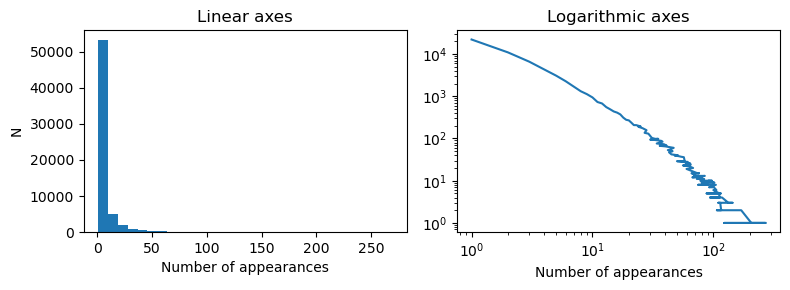

In [167]:
#2 subplots
fig, ax = plt.subplots(1,2, figsize=(8,3))

#group by number of appearances and sort
act = actors.groupby('appearances')['appearances'].count().sort_values(ascending=False)

sbplt = ax[0]
sbplt.hist(actors.appearances, bins=30)
sbplt.set_title('Linear axes')
sbplt.set_xlabel('Number of appearances')
sbplt.set_ylabel('N')

sbplt = ax[1]
sbplt.loglog(act.index,act.values)
sbplt.set_title('Logarithmic axes')
sbplt.set_xlabel('Number of appearances')
    
fig.tight_layout()
plt.savefig('../figures/power_law.png', bbox_inches='tight')
plt.show()

The appearances distribution split by gender shows differences between actors and actresses career. The trends are similar (power-law distributions), but there are systematic differences between the two. Moreover, the percentage of actresses is lower than the percentage of actors in the dataset (36%)
This is a possible confounder to be tackled when conducting the observational study.

In the second graphs below (semilogarithmic y axis), the power law is further confirmed by its typical exponential tail, due to the fact that the considered system has a finite size. A Kolmogorov–Smirnov test is performed to actually verify that the tail is exponential and therefore that we are dealing with a power law. The test is performed on appearances belonging to the interval $[2,10]$, given that 1 is a clear outlier.

Source: O. E. Williams, L. Lacasa & V. Latora, Quantifying and predicting success in show business, Nature Communications, 2019. https://doi.org/10.1038/s41467-019-10213-0

In [168]:
actors1 = actors[actors['appearances'] > 1]

In [169]:
#split into actors/actresses
dt1 = actors[actors['gender'] == 'M']
dt2 = actors[actors['gender'] == 'F']

#group by number of appearances and sort
act1 = dt1.groupby('appearances')['appearances'].count().sort_values(ascending=False)
act2 = dt2.groupby('appearances')['appearances'].count().sort_values(ascending=False)

In [170]:
#fraction of actresses in the dataset
print(len(dt2)/len(actors))

0.3951645056855334


In [171]:
len(actors)

62703

The results of the Kolmogorov–Smirnov test are diplayed in the cell below, for the overall dataset and for the two datasets split on gender. The p-values are larger than 0.05, therefore the null-hypothesis of the distributions being exponential cannot be rejected.

In [172]:
#kolmogorov-smirnov test for exponential distribution
from statsmodels.stats import diagnostic

print('Overall dataset: ' + str(diagnostic.kstest_normal(act.values[2:10], dist = 'exp'))) #overall dataset
print('Actors dataset: ' + str(diagnostic.kstest_normal(act1.values[2:10], dist = 'exp'))) #actors dataset
print('Actresses dataset: ' + str(diagnostic.kstest_normal(act2.values[2:10], dist = 'exp'))) #actresses dataset

Overall dataset: (0.29718720994901426, 0.19221616388052742)
Actors dataset: (0.2995158474654613, 0.18509461865372379)
Actresses dataset: (0.29360285359077093, 0.2031780056158432)


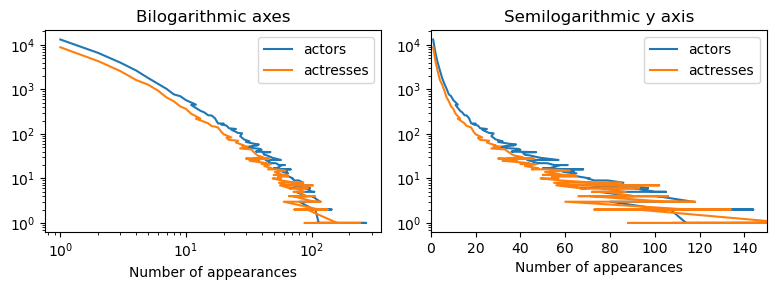

In [173]:
#2 subplots
fig, ax = plt.subplots(1,2, figsize=(8,3))

sbplt = ax[0]
sbplt.loglog(act1.index,act1.values, label='actors')
sbplt.loglog(act2.index,act2.values, label='actresses')
sbplt.set_title('Bilogarithmic axes')
sbplt.set_xlabel('Number of appearances')
sbplt.legend()

sbplt = ax[1]
sbplt.semilogy(act1.index,act1.values, label='actors')
sbplt.semilogy(act2.index,act2.values, label='actresses')
sbplt.set_xlim((0,150))
sbplt.set_title('Semilogarithmic y axis')
sbplt.set_xlabel('Number of appearances')
sbplt.legend()

fig.tight_layout()
plt.savefig('../figures/pow_gender.png', bbox_inches='tight')
plt.show()

To prove the statistical significance of the gender bias in the distribution, two exponential fittings are implemented in the tails of the distribution and compared with a fitting on the overall dataset. 

An Mann-Whitney U test is also performed to verify if the difference between the distributions of datasets split on gender is statistically significant. The resulting p-values are lower than the imposed threshold (0.05), therefore the null hypothesis that the averages are equal is rejected. There is a gender bias in the dataset.

In [174]:
#appearances of actors/actresses
stats.mannwhitneyu(dt1.appearances, dt2.appearances) #independent test

MannwhitneyuResult(statistic=475461340.5, pvalue=0.009399126999894725)

Moreover, from the following bar plots, there is a visible gender difference in average appearances and ratings in the movies the actors starred in (also accounting for the 95% confidence intervals). However, in terms of ratings in the movie they starred in, there seems to be no significant difference.

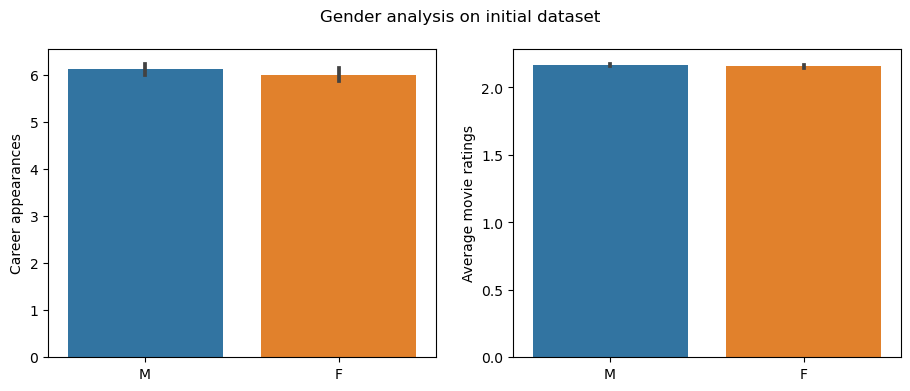

In [175]:
#bar plot with 95% confidence intervals
import seaborn as sns

#3 subplots
fig, ax = plt.subplots(1,2, figsize=(11,4))

sbplt = ax[0]
sns.barplot(ax=ax[0], x="gender", y="appearances", data=actors)
sbplt.set_ylabel('Career appearances')
sbplt.set_xlabel('')

sbplt = ax[1]
sns.barplot(ax=ax[1], x="gender", y="grade_avg", data=actors)
sbplt.set_ylabel('Average movie ratings')
sbplt.set_xlabel('')
    
#fig.tight_layout()
plt.rcParams.update({'font.size': 10})
plt.savefig('../figures/gender1.png', bbox_inches='tight')
fig.suptitle('Gender analysis on initial dataset')
plt.show()

Supported by rich-get-richer mechanism assumption, the treatment group will be the group with the higher number of appearances. We want to capture the influence of different factors on the productivity of actors' careers (the fact that they keep acting). The splitting of the dataset will be carried out based on the median of the distribution, more representative than the mean when considering skewed distributions.

Of course, younger actors may have lower number of appearances only because they are at the beginning of their career. This possible confounder must be considered in the study and the birthdate of the actors is taken into account in the propensity score matching.

In [47]:
#median
print('The median of the distribution is ' + str(np.median(actors.appearances)))
print('The mean of the distribution is ' + str(np.mean(actors.appearances)))

The median of the distribution is 2.0
The mean of the distribution is 6.075626365564646


In [79]:
threshold = np.percentile(actors.appearances,80)
print(threshold)

7.0


In [49]:
#split into treatment and control groups
actors['treatment'] = (actors['appearances'] > threshold).astype(int)

To limit the effect of confounders, the individuals of the groups will be matched on propensity score, namely the probability of being in the treatment group based on observed covariates. The considered observed covariates will be:

- Main genre of the movies they acted in;
- 2nd main genre of the movies they starred in;
- birthdate;
- gender.

The *genre* could have a strong confounding effect, given that Action/Adventure movies have generally more viewers than other movie categories, therefore, incllufing both main and 2nd main genre in the actor's career would limit the effect of such a confounder.

Regarding the *gender*, to further balance the dataset, the matching will be perfect based on gender. This means that an actors will be matched with another actor and an actress with another actress.

To extract the propensity scores, a logistic regression is trained and applied on the same dataset, this will output the needed probabilities. It is worth mentioning that the revenues and ratings are characteristics that define the success of the movie and that will set the basis for the definition of the *star score*. Therefore, they are not included in the matching features, otherwise they would bias the process of identification of successful actors.

In [178]:
actors.dropna(subset=['main_genre'],inplace=True)
len(actors)

62703

In [83]:
(actors['year_avg'] > 1970).sum()

125076

In [186]:
actors['birth_year'] = actors['birth_year'].apply(lambda x: float(x))

In [187]:
actors.head()

,Unnamed: 0,actor,grade_avg,grade_sum,appearances,main_genre,2nd_genre,director,2nd_director,gender,year_avg,treatment,birth_year
0,0,William_Courtenay,1.961308,5.883925,3,Drama,NaN,John_G._Adolfi,Alexander_Black,M,2007.0,0,1899.0
3,3,John_Tait,2.708095,2.708095,1,Adventure,NaN,Charles_Tait,NaN,M,1951.0,0,1949.0
4,4,Nicholas_Brierley,2.708095,2.708095,1,Adventure,NaN,Charles_Tait,NaN,M,1937.0,0,1918.0
5,5,Norman_Campbell,2.708095,2.708095,1,Adventure,NaN,Charles_Tait,NaN,F,1937.2,0,1915.0
6,6,Elizabeth_Tait,2.708095,2.708095,1,Adventure,NaN,Charles_Tait,NaN,M,2016.0,0,1899.0


In [9]:
X = actors[{'main_genre','director','year_avg','birth_year'}]

In [10]:
X = pd.get_dummies(X,columns=['main_genre','director'])
y = actors['treatment']

In [11]:
X.head(3)

,year_avg,birth_year,main_genre_Adult,main_genre_Adventure,main_genre_Animation,main_genre_Biography,main_genre_Comedy,main_genre_Crime,main_genre_Documentary,main_genre_Drama,...,director_Éric_Rohmer,director_Étienne_Chatiliez,director_Étienne_Faure,director_Óscar_Aibar,director_Óskar_Jónasson,director_Ömer_Kavur,director_Ümit_Ünal,director_Þorsteinn_Jónsson,director_Þráinn_Bertelsson,director_Þórhildur_Þorleifsdóttir
0,2007.0,1899.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1951.0,1949.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1937.0,1918.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#regression
X['year_avg'] = (X['year_avg'] - X['year_avg'].mean())/X['year_avg'].std()
X['birth_year'] = (X['birth_year'] - X['birth_year'].mean())/X['birth_year'].std()

In [13]:
#logistic regression model
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(X,y) #train

LogisticRegression(max_iter=10000)

In [14]:
#extract propensity scores
actors['propensity_score'] = [i[0] for i in list(logistic.predict_proba(X))]

In [15]:
#display propensity scores
actors[['propensity_score']].head()

,propensity_score
0,0.558610
1,0.784121
2,0.751909
3,0.748639
4,0.731402


In [22]:
actors_cut = actors[actors['birth_year'] > 1930]
len(actors_cut)

47260

Given the extremely large size of the dataset and the matching time needed to minimize the similarity difference between all the possible combinations, the matching is carried out by ordering the dataset by propensity scores, splitting it into smaller sets and performing the matching on each. The method is valid because each smaller set will have the most similar propensity scores (method suggestes by Prof. Bob West).

In [19]:
#function to compute similarity (difference between propensity scores to be minimized in the matching)
def get_similarity(prop1,prop2):
    return 1-abs(prop1-prop2)

In [20]:
#sort dataset by propensity score
actors_prop = actors_cut.sort_values(by=['propensity_score'],ascending=True).reset_index()

In [50]:
threshold

7.0

In [45]:
#define matrix with the indexes of the multiple groups on each row
count = np.array(actors_prop.index).reshape(170,278)

In [51]:
T = pd.DataFrame([]) #initialize auxiliary matrix

for i in range(len(count)):
    
    #define treatment and control groups
    treat = actors_prop.loc[count[i,:]][actors_prop['appearances'] > threshold]
    contr = actors_prop.loc[count[i,:]][actors_prop['appearances'] <= threshold]
    
    G = nx.Graph() #create empty undirected graph
    
    for i, j in contr.iterrows():
        for k, l in treat.iterrows():
            if j['gender'] == l['gender']: #perfect match on gender
                #Calculate the similarity 
                similarity = get_similarity(j['propensity_score'],
                                            l['propensity_score'])

                #Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(i, k, similarity)])
            
    matching = nx.max_weight_matching(G) #perform the matching

    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)] #create list with all indexes of people paired

    balanced_df = actors_prop.loc[matched] #extract only rows with paired subjects
    
    T = T.append(balanced_df) #append to auxiliary matrix

In [52]:
#export balanced dataset
T.to_csv('../data/balanced_df.csv')

In [53]:
#import balanced dataset
balanced_df = pd.read_csv('../data/balanced_df.csv', index_col=0)
balanced_df.head()

,index,Unnamed: 0.1,Unnamed: 0,actor,grade_avg,grade_sum,appearances,main_genre,2nd_genre,director,2nd_director,gender,year_avg,treatment,birth_year,propensity_score
136,18894,24900,24900,Michael_Sacks,3.816808,15.267230,4,Drama,NaN,Steven_Spielberg,Donald_Wrye,F,2011.571429,1,1973.0,0.175791
243,22642,29877,29877,Fred_Willard,3.520822,98.583025,28,Animation,Music,Christopher_Guest,Andrew_Stanton,M,1951.941176,1,1957.0,0.189205
249,4812,6614,6614,Simone_Simon,3.051534,91.546033,30,Drama,Fantasy,William_Dieterle,Robert_Wise,M,1986.000000,1,1964.0,0.189757
266,6136,8381,8381,Barry_Jones,2.716687,19.016807,7,Drama,Crime,Ralph_Thomas,Albert_Parker,M,2007.957746,1,1956.0,0.191004
58,5104,6991,6991,Jean_Rogers,1.999881,81.995107,41,Drama,Romance,George_Sidney,Lew_Landers,M,2014.166667,1,1932.0,0.160031


In [65]:
print('We matched ' + str(len(balanced_df)) + ' actors')
print('We discarded ' + str(len(actors)-len(balanced_df)) + ' actors')

We matched 15330 actors
We discarded 47373 actors


To capture the influence of the average revenues and ratings of actors' careers, a linear regression is implemented on the balanced dataset. The summary is shown below.

In [66]:
#regression
X1 = balanced_df[{'treatment','grade_avg'}]
X1['grade_avg'] = (X1['grade_avg'] - X1['grade_avg'].mean())/X1['grade_avg'].std()
    
import statsmodels.formula.api as smf
    
mod = smf.ols(formula='grade_avg ~ treatment',
              data=X1)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              grade_avg   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     149.8
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           2.77e-34
Time:                        14:23:09   Log-Likelihood:                -21677.
No. Observations:               15330   AIC:                         4.336e+04
Df Residuals:                   15328   BIC:                         4.337e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1714      0.016    -10.615      0.0

In [85]:
print(len(balanced_df))

15330


In [82]:
print(actors.appearances.median())
print(actors.appearances.std())
print(np.percentile(actors.appearances,80))
print(np.percentile(actors.appearances,25))

2.0
11.549479298676623
7.0
1.0


In [80]:
print(balanced_df.appearances.median())
print(balanced_df.appearances.std())
print(np.percentile(balanced_df.appearances,80))
print(np.percentile(balanced_df.appearances,25))

7.5
16.21647723697613
17.0
4.0


In [81]:
male_df = balanced_df[balanced_df['gender'] == 'M']
female_df = balanced_df[balanced_df['gender'] == 'F']

In [86]:
len(male_df)/len(balanced_df)

0.5920417482061318

From the results, it it possible to observe that there is a positive correlation with the revenues and a negative correlation with the ratings, both statistically significant given that the p-values are lower than the imposed threshold (0.05). The negative correlation with the ratings is interesting, because it is counter-intuitive. A possible explanation of such correlation is that, generally speaking, movies with a big impact (e.g., big revenue and rating) tend to have sequels, where the actors' cast is roughly the same, but the movie quality decreases with respect to the first movie, or at least it cannot stand the high expectancies of it. But let's the data speak!

PROVE THIS!!!

The *star score* can eventually be defined based on the above analysis.

$star\ score = (A + \ln{\bar{R}})^{\log{(\bar{G})}}$

where $A$ is the number of appearances in the actor's career and $\bar{G}$, $\bar{R}$ are the averages of the revenues and ratings 'caused' to the movies he starred in. In this case the average is appropriate because the distribution of such parameters in actors careers is not a power law.

This formulation of the star score captures the three parameters of interest chosen to assess the impact of an actor on movies. To give importance to the revenues that actors cause to movies, a linear combination of log of average revenues and number of career appearances (productivity) is suitable to give both factors comparable weights. Moreover, given that the ratings range from 1 to 10, exponentiating with log base 10 of the average ratings would keep the base as it is for a maximum rating and decrease it for a drop in rating. Here, the exponential increase is suitable because of the will to give a larger weight to actors that manage to significantly affect the movie rating, given the previously found trend of negative correlation with appearances.

We believe this metric includes the parameters of interest that relate an actor to the success of the movie. Of course it is possible to argue that many other factors may be taken into consideration, but the goal of the present study is to assess by a certain order the actors' impact. We are aware of the possible margins of error.

In [50]:
#add star scores
balanced_df['star_score'] = (balanced_df['appearances'] + balanced_df['log_revenue'])**np.log10(balanced_df['grade_avg'])

In [51]:
balanced_df.sort_values('star_score', inplace=True, ascending=False)

In [52]:
balanced_df.head(3)

,index,actor,revenue_avg,grade_avg,revenue_sum,grade_sum,appearances,main_genre,2nd_genre,country1,country2,tenure,gender,birthdate,log_revenue,treatment,propensity_score,star_score
9306,7012,Frank_Welker,2.442829e+08,5.106723,1.465697e+10,306.403368,60,Adventure,Family Film,United States of America,Japan,28.0,M,1930,19.313837,1,0.668033,22.131422
1675,6799,Johnny_Depp,2.113608e+08,5.554156,8.665791e+09,227.720408,41,Drama,Comedy,United States of America,United Kingdom,28.0,M,1933,19.169077,1,0.207925,21.132632
14456,9669,Hugo_Weaving,4.590775e+08,6.243520,1.101786e+10,149.844479,24,Science Fiction,Adventure,United States of America,Australia,21.0,M,1924,19.944730,1,0.803309,20.268263


The distribution of the star scores in the dataset is shown below. As expected, the distribution is  skewed, because of the previously explained rich-get-richer mecahnism. However, the distribution is not a power law, given that it is not a straight line in the logarithmic domain. In the linear plot, there is a first trait of very high star scores, then a linear decrease to roughly the 90th percentile of the actors and eventually a rapid drop for the less-successful actors.
It is interesting to comment the linear behavior in the middle of the distribution. Indeed, it seems that the difference in movie impact between actors with high movie appearances and actors with lower ones is not as steep a is may seem by only analysing the productivity of the actors (from first power law graph).

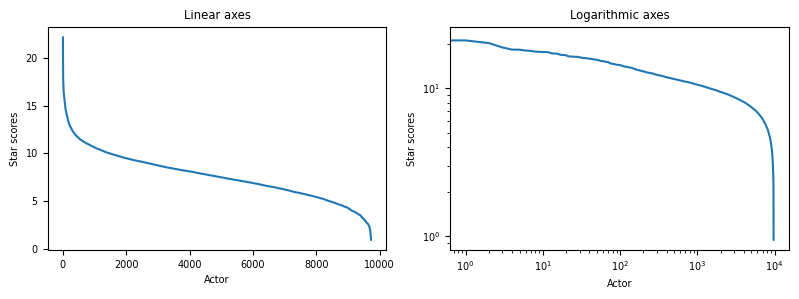

In [53]:
#2 subplots
fig, ax = plt.subplots(1,2, figsize=(8,3))

sbplt = ax[0]
sbplt.plot(np.arange(0,len(balanced_df)),balanced_df.star_score)
sbplt.set_title('Linear axes')
sbplt.set_ylabel('Star scores')
sbplt.set_xlabel('Actor')

sbplt = ax[1]
plt.loglog(np.arange(0,len(balanced_df)),balanced_df.star_score)
sbplt.set_title('Logarithmic axes')
sbplt.set_ylabel('Star scores')
sbplt.set_xlabel('Actor')

fig.tight_layout()
plt.show()

In [54]:
balanced_df.to_csv('../data/balanced_df.csv')

It is interesting to investigate the birthdate distribution of average star scores, shown in the plot below (split by gender). First of all, it is interesting to notice that the highest average star scores are concentrated in actors with the most recent birthdates (roughly 1980-2000) and with the less recent ones (roughly 1880). Actors born in the middle of these periods follow a steady trend. The first peak could be related with *Hollywood's golden age* (1930s-1940s), namely the beginning of the sound movies and one of the most productive periods in Hollywood history. Indeed, as a remainder, the revenues were corrected taking inflation into account, therefore the revenues between time periods are comparable.
Regarding the peaks in most recent movie history, it could be related to the increasing diffusion of technology and easiness of access to content, or by the fact that the number of people watching the movies is large and consequently the number of movie rating is increased (remainder that the ratings are normalized on the number of votes; the more votes, the higher the weight of the rating).

Investigating the gender differences, it is curious how actresses dominate in star score during the first period (way higher than actors), while the opposite trend is observed for the rest of the time periods (except a couple years like 1965 and 1985).

In [56]:
#group by birthdate
df_birthdate = balanced_df.groupby('birthdate')['star_score'].mean()

In [57]:
#split into actors/actresses
df_m = balanced_df[balanced_df['gender'] == 'M']
df_f = balanced_df[balanced_df['gender'] == 'F']

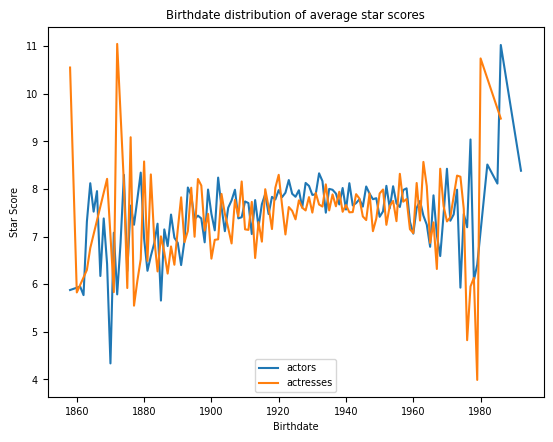

In [115]:
dfm_birthdate = df_m.groupby('birthdate')['star_score'].mean()
dff_birthdate = df_f.groupby('birthdate')['star_score'].mean()

#plt.plot(df_birthdate.index,df_birthdate.values)
plt.plot(dfm_birthdate.index,dfm_birthdate.values,label='actors')
plt.plot(dff_birthdate.index,dff_birthdate.values,label='actresses')
plt.legend()
plt.title('Birthdate distribution of average star scores')
plt.ylabel('Star Score')
plt.xlabel('Birthdate')
plt.savefig('../figures/birthdate.png', bbox_inches='tight')
plt.show()

The trends in the genres of movies that have larger impact. This plot could show if the preferences of the audience are diversified or if they tend to stick to certain types of films.

In the first bar plot (red palette), the distribution of actors per genre is strongly skewed (log y axis), where the most popular categories are *Comedy*, *Drama* and *Action*. However, the average star scores per genre show a different trend (blue palette). The star scores are comparable between different genres (linear y axis), and the genres with highest average star scores are the ones with less actors starring in them. The highest average star scores is obtained by the category *Parody*. This could be explained because in such genre categories there is less competition (less movies produced), therefore the audience is less distributed over all the movies produced and the single actor can more easily have an impact on the revenue. Moreover, there are less famous actors in Parody movies with respect to Action, Drama and Comedy, therefore the few Parody actors joining the rich-get-richer circle keep starring and increasing their number of appearances and their success.

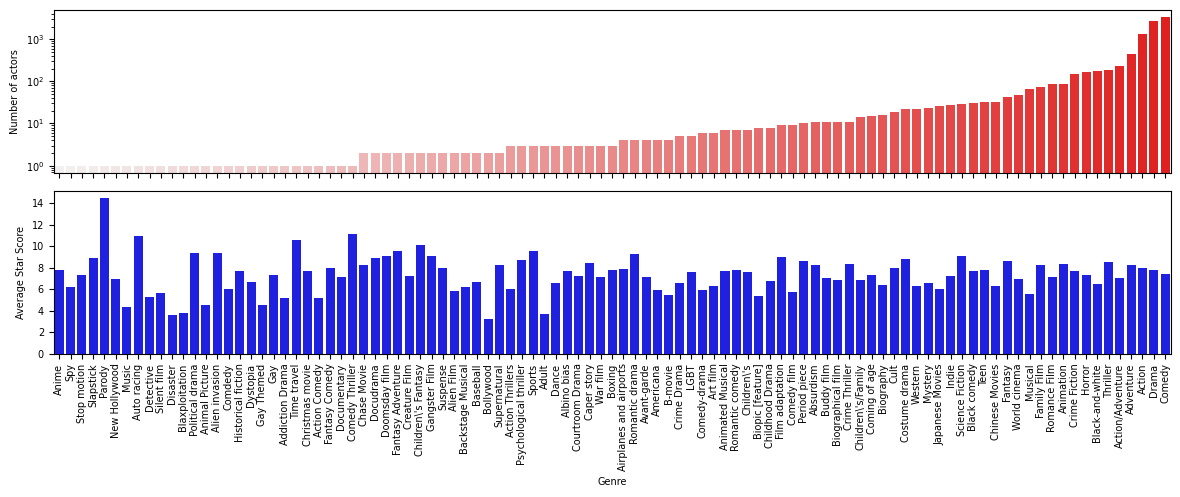

In [183]:
#group average star scores by main actor genre and count actors by main genre
df_genre = balanced_df.groupby('main_genre')['star_score'].agg(['mean','count']).sort_values('count',ascending=True)

# setting the dimensions of the plot
fig, ax = plt.subplots(2,1, figsize=(12, 4), sharex=True)

sbplt = ax[1]
sns.barplot(ax=ax[1],x=df_genre.index,y=df_genre['mean'],color='blue')
sbplt.set_ylabel('Average Star Score')
sbplt.set_xlabel('Genre')

sbplt = ax[0]
sns.barplot(ax=ax[0],x=df_genre.index,y=df_genre['count'],palette='light:r')
sbplt.set_yscale("log")
sbplt.set_xlabel('')
sbplt.set_ylabel('Number of actors')

fig.tight_layout()
plt.xticks(rotation=90)
plt.savefig('../figures/genres.png', bbox_inches='tight')
plt.show()

In [191]:
dt = pd.read_csv('../data/data_underscore.csv')
balanced_data = dt[dt['actor'].isin(balanced_df['actor'])]

In [195]:
balanced_data.head(3)

,Unnamed: 0,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,averageRating,numVotes,genres,countries,box_office_adj,numVotes_factor,averageRating_adj,actor
0,0,Dustin Farnum,M,1874-05-27,The Squaw Man,1914.0,244700.0,74.0,5.833333,1418,"[' ""Silent film""', ' ""Western""', ' ""Drama""', '...","[' ""United States of America""}']",6.117500e+06,0.490549,2.861536,Dustin_Farnum
7,7,Henry B. Walthall,M,1878-03-16,The Birth of a Nation,1915.0,50000000.0,190.0,6.600000,46186,"[' ""Silent film""', ' ""Indie""', ' ""Costume dram...","[' ""United States of America""}']",1.250000e+09,0.726017,4.791714,Henry_B._Walthall
15,15,Burr McIntosh,M,1862-08-21,Way Down East,1920.0,4500000.0,147.0,6.750000,5791,"[' ""Silent film""', ' ""Indie""', ' ""Black-and-wh...","[' ""United States of America""}']",5.625000e+07,0.585661,3.953215,Burr_McIntosh


In [206]:
G = nx.MultiDiGraph()

for i,j in balanced_data.iterrows():
    G.add_edge(j.actor,j.Movie_name)

In [207]:
print(len(G.nodes)) #number of nodes
print(len(G.edges)) #number of edges
print(len(G.edges)/len(G.nodes)) #average degree

16859
39506
2.3433181090218875


The next analysis will investigate the change in star score over the actors' movies. Indeed, for a movie director, knowing if the actor's star score (impact on movies) has been raising or dropping over his recent movies, can be a hiring metric. Given that the star score tends always increases over an actor's career (given that the appearances can only increase), a suited approach would be to look at the relative increase.

,region,title
104,IT,3979858


In [325]:
appearances = it.groupby('actor')['title'].count().sort_values(ascending=False).reset_index()

In [329]:
it.head()

,Unnamed: 0,tconst,title,year,genres,averageRating,numVotes,Director,category,actor,titleId,ordering,region,language,types,attributes,isOriginalTitle
79,19,tt0000630,Hamlet,1908,Drama,2.9,25,Mario Caserini,actress,Fernanda Negri Pouget,tt0000630,1,IT,\N,imdbDisplay,\N,0
112,36,tt0001112,Amleto,1910,Drama,3.8,42,Mario Caserini,actor,Dante Cappelli,tt0001112,1,IT,\N,imdbDisplay,\N,0
116,37,tt0001112,Amleto,1910,Drama,3.8,42,Mario Caserini,actress,Maria Caserini,tt0001112,1,IT,\N,imdbDisplay,\N,0
954,203,tt0002445,Quo Vadis?,1913,"Drama,History",6.2,378,Enrico Guazzoni,actor,Amleto Novelli,tt0002445,4,IT,\N,imdbDisplay,\N,0
964,204,tt0002445,Quo Vadis?,1913,"Drama,History",6.2,378,Enrico Guazzoni,actor,Gustavo Serena,tt0002445,4,IT,\N,imdbDisplay,\N,0


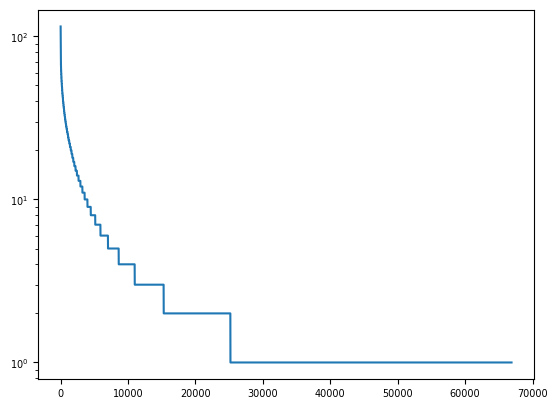

In [327]:
plt.semilogy(appearances.index,appearances.title)

In [244]:
appearances = df.groupby('ActorName')['primaryTitle'].count().sort_values(ascending=False).reset_index()

In [235]:
appearances = appearances[appearances > 1].reset_index()

In [245]:
appearances

,ActorName,primaryTitle
0,Brahmanandam,382
1,Mithun Chakraborty,300
2,Mammootty,291
3,Mohanlal,289
4,Cüneyt Arkin,268
...,...,...
349890,Jae Liew,1
349891,Jae McCain,1
349892,Jae Phan,1
349893,Jae Seymour,1


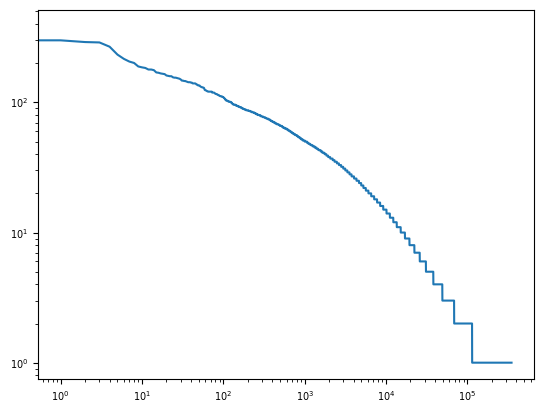

In [246]:
plt.loglog(appearances.index,appearances.primaryTitle)